In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Necessary Libraries

In [2]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

2024-05-25 12:36:47.962376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 12:36:47.962506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 12:36:48.077493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Explore the Dataset

In [3]:
next(os.walk('/kaggle/input/state-farm-distracted-driver-detection'))

('/kaggle/input/state-farm-distracted-driver-detection',
 ['imgs'],
 ['sample_submission.csv', 'driver_imgs_list.csv'])

In [4]:
path='/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv'
df=pd.read_csv(path)
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [5]:
len(df.subject.value_counts().keys())

26

### Hence, number of unique drivers is 26

## Display the Class Paths

In [6]:
next(os.walk('/kaggle/input/state-farm-distracted-driver-detection/imgs'))

('/kaggle/input/state-farm-distracted-driver-detection/imgs',
 ['test', 'train'],
 [])

In [7]:
next(os.walk('/kaggle/input/state-farm-distracted-driver-detection/imgs/train'))

('/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
 ['c5', 'c7', 'c8', 'c2', 'c6', 'c4', 'c3', 'c1', 'c9', 'c0'],
 [])

In [8]:
class_paths=[]
for dirname, _, filenames in os.walk('/kaggle/input/state-farm-distracted-driver-detection/imgs/train'):
    for a in _:
        cls_path=os.path.join(dirname, a)
        print(cls_path)
        class_paths.append(cls_path)

/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c7
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c2
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c6
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c4
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c1
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c9
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0


In [9]:
a,b,c=next(os.walk(class_paths[0]))
a,b,c[:10]

('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5',
 [],
 ['img_68208.jpg',
  'img_77583.jpg',
  'img_49189.jpg',
  'img_6690.jpg',
  'img_95740.jpg',
  'img_28635.jpg',
  'img_37376.jpg',
  'img_8327.jpg',
  'img_41485.jpg',
  'img_94685.jpg'])

## Display Sample Image

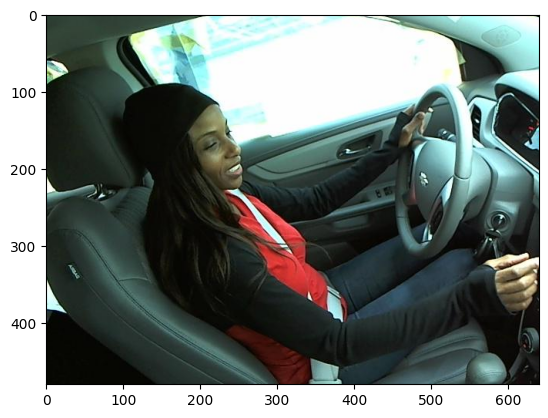

(480, 640, 3)

In [10]:
image1=cv2.cvtColor(cv2.imread('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_68208.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(image1)
plt.show()
image1.shape

## Prepare Training Data

In [11]:
train1=[]
labels=[]
for class_path in class_paths:
    a_,b_,c_=next(os.walk(class_path))
#     print(a_,b_,c_)
    for c__ in c_:
        img_path=os.path.join(a_, c__)
#         print(a_[-1:], img_path)
        img=cv2.imread(img_path, cv2.IMREAD_COLOR)
        img=cv2.resize(img, (96,96))
        train1.append(img)
        labels.append(int(a_[-1:]))
#         break

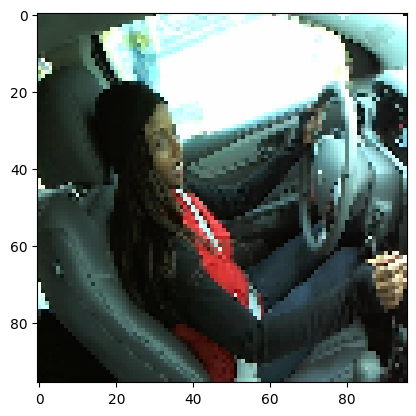

In [12]:
plt.imshow(cv2.cvtColor(train1[0], cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
print(np.array(labels).shape)
print(labels[:10])

(22424,)
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


## One-Hot Encoding

In [14]:
y = tf.keras.utils.to_categorical(labels, 10)
print(type(y))
y[:10]

<class 'numpy.ndarray'>


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

## Normalize Data

In [15]:
# train=np.array(train, dtype=np.uint8).reshape(-1, 160, 160, 3)
train=np.array(train1, dtype=np.float32).reshape(-1, 96, 96, 3)
print(np.max(train))
train=train/255
print(np.max(train))

255.0
1.0


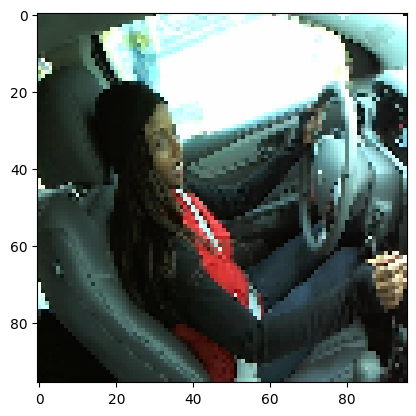

In [16]:
plt.imshow(cv2.cvtColor(train[0], cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
type(train)

numpy.ndarray

In [18]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Split Data into Train and Test Sets

In [19]:
X_train, X_test, y_train, y_test=train_test_split(train, y, test_size=0.2, random_state=0, stratify=labels)
print("Train label distribution:", np.sum(y_train, axis=0))
print("Test label distribution:", np.sum(y_test, axis=0))

Train label distribution: [1991. 1814. 1853. 1877. 1861. 1849. 1860. 1602. 1529. 1703.]
Test label distribution: [498. 453. 464. 469. 465. 463. 465. 400. 382. 426.]


## Build CNN Model

In [20]:
model=Sequential()
model.add(InputLayer(shape=(96,96,3)))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))



In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     9,216,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,848,006 (41.38 MB)

 Trainable params: 10,848,006 (41.38 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Set Up Callbacks

In [23]:
checkpointer=ModelCheckpoint(
    'saved_models/weights_best_vanilla.keras',
#     monitor='val_loss',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
)

In [24]:
es=EarlyStopping(monitor='val_loss',mode='auto',verbose=1,patience=2,restore_best_weights=True)

In [25]:
X_train.shape

(17939, 96, 96, 3)

## Train the Model

In [26]:
# model.fit(
#     x=X_train,
#     y=y_train,
#     batch_size=40,
#     epochs=10,
#     verbose=1,
#     callbacks=[checkpointer, es],
# #     callbacks=[ checkpointer],
#     validation_data=(X_test, y_test),
# #     shuffle=True,
# )
model.fit(
    x=X_train,
    y=y_train,
    batch_size=40,
    epochs=10,
    verbose='auto',
    callbacks=[checkpointer, es],
    validation_split=0.1,
#     validation_data=None,
    shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epoch=0,
#     steps_per_epoch=None,
#     validation_steps=None,
#     validation_batch_size=None,
#     validation_freq=1
)

Epoch 1/10
  7/404 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1121 - loss: 3.9504

I0000 00:00:1716640880.617456      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716640880.637650      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3104 - loss: 1.9457

W0000 00:00:1716640895.857009      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.27845, saving model to saved_models/weights_best_vanilla.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.3111 - loss: 1.9439 - val_accuracy: 0.9259 - val_loss: 0.2784
Epoch 2/10
402/404 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9196 - loss: 0.2722
Epoch 2: val_loss improved from 0.27845 to 0.13182, saving model to saved_models/weights_best_vanilla.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9197 - loss: 0.2719 - val_accuracy: 0.9682 - val_loss: 0.1318
Epoch 3/10
403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9596 - loss: 0.1484
Epoch 3: val_loss improved from 0.13182 to 0.12464, saving model to saved_models/weights_best_vanilla.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9596 - loss: 0.1483 - val_accuracy: 0.9732 - val_loss: 0.1246
Epoch 4/10
403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9727 - loss: 0.0993
Epoch 4: val_loss improved from 0.12464 to 0.07067, saving mode

## Evaluate the Model

In [27]:
model.evaluate(X_test, y_test)

141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9881 - loss: 0.0486


[0.29570913314819336, 0.9870679974555969]